<a href="https://colab.research.google.com/github/adammuhtar/sierra/blob/main/notebooks/table-extraction-lmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tabular Information Extraction via Large Multi-modal Models**

*- [Adam Muhtar](mailto:Adam.Muhtar@bankofengland.co.uk)*

---

This notebook provides a high-level overview of the code used for information extraction of tables via large multi-modal models, e.g. OpenAI's [GPT-4o](https://openai.com/index/hello-gpt-4o/).

## **Table of Contents**

* [1. Notebook setup](#section-1)
* [2. Load OpenAI API credentials](#section-2)
* [3. Transforming PDF pages to images](#section-3)
* [4. Tabular information extraction via OpenAI API with multi-modal inputs (text + image)](#section-4)
  * [4.1 Test set 1](#section-4-1)
  * [4.2 Test set 2](#section-4-2)
  * [4.3 Test set 3](#section-4-3)
  * [4.4 Test set 4](#section-4-4)

## 1. Notebook Setup <a id="section-1"></a>

This notebook runs on Python 3.11.9 and will require the following package(s) to be installed:
* `openai~=1.38.0`
* `Pillow~=10.4.0`
* `python-dotenv~=1.0.1`
* `pymupdf~=1.24.9`

Hardware accelerators (e.g. GPUs, TPUs) are not required for this notebook.

In [ ]:
# Standard library imports
import base64
import logging
from mimetypes import guess_type
from pathlib import Path
from typing import Literal, Optional, Union

# Third-party imports
from dotenv import dotenv_values
from openai import OpenAI
from PIL import Image
import pymupdf

## 2. Load OpenAI API credentials <a id="section-2"></a>

To obtain an OpenAI API key, follow these steps:

1. **Visit the OpenAI Platform**: Go to the [OpenAI Platform](https://platform.openai.com/) and log in with your account credentials.
2. **Navigate to API Keys Section**: Once logged in, click on your profile icon or name at the top right corner. From the dropdown menu, select "API Keys."
3. **Create a New API Key**: In the API Keys section, you will see an option to create a new API key. Click on "Create API Key," and a new key will be generated for you. Be sure to copy this key and store it securely.

The API key should be stored into your respective `.env.secret` file, and should not be shared publicly. The structure of the `.env` file is a series of key-value pairs delimited by an `=` sign, e.g.:
```
OPENAI_API_KEY="abcdef1234567890"
```

Refer to the existing `.env.shared` file in the `.config` folder for reference. For more details on how to set up your API key and best practices for using it, visit the [OpenAI API Quickstart Guide](https://platform.openai.com/docs/quickstart/step-2-setup-your-api-key)


In [ ]:
# Configure logging
logging.basicConfig(
    level=logging.WARNING, format="%(asctime)s - %(levelname)s - %(message)s"
)

# Load config files
try:
    shared_env = Path.cwd().parent / ".config" / ".env.shared"
    secret_env = Path.cwd().parent / ".config" / ".env.secret"
    config = {
        **dotenv_values(str(shared_env)),
        **dotenv_values(str(secret_env))
    }
    client = OpenAI(api_key=config["OPENAI_API_KEY"])
    logging.info("Azure OpenAI credentials successfully loaded")
except FileNotFoundError:
    logging.error(f"Environment files {shared_env}/{secret_env} not found")
    raise
except KeyError:
    logging.error(f"API credentials in {shared_env}/{secret_env} not formatted correctly")
    raise
except Exception as e:
    logging.error(f"An error occurred while loading the API key: {e}")
    raise

## 3. Transforming PDF pages to images<a id="section-3"></a>

We first convert the given page of interest into an image, which will then be used as part of a multi-modal input for the OpenAI API.

In [ ]:
def pdf_page_to_image(
    pdf_path: Path, page_number: int, output_image_path: Path
) -> Optional[Path]:
    """
    Convert a specific page from a PDF to an image.

    Args:
        * pdf_path (`Path`): Path to the PDF file.
        * page_number (`int`): Page number to be converted (0-indexed).
        * output_image_path (`Path`): Path to save the output image.

    Returns:
        Path to the saved image or None if an error occurs.
    """
    try:
        pdf_document = pymupdf.open(str(pdf_path))
    except Exception as e:
        logging.error(f"Error opening PDF file: {e}")
        raise

    # Check if the page number is within the valid range
    if page_number < 0 or page_number >= pdf_document.page_count:
        print(
            f"Invalid page number: {page_number}. The document has {pdf_document.page_count} pages."
        )
        pdf_document.close()
        return None

    try:
        page = pdf_document.load_page(page_number)  # Select the specified page
        pix = page.get_pixmap()                     # Page-to-image conversion
        pix.save(str(output_image_path))            # Save the image
    except Exception as e:
        print(f"Error processing page: {e}")
        return None
    finally:
        if not pdf_document.is_closed:
            pdf_document.close()                    # # Ensure the PDF is closed

    return output_image_path

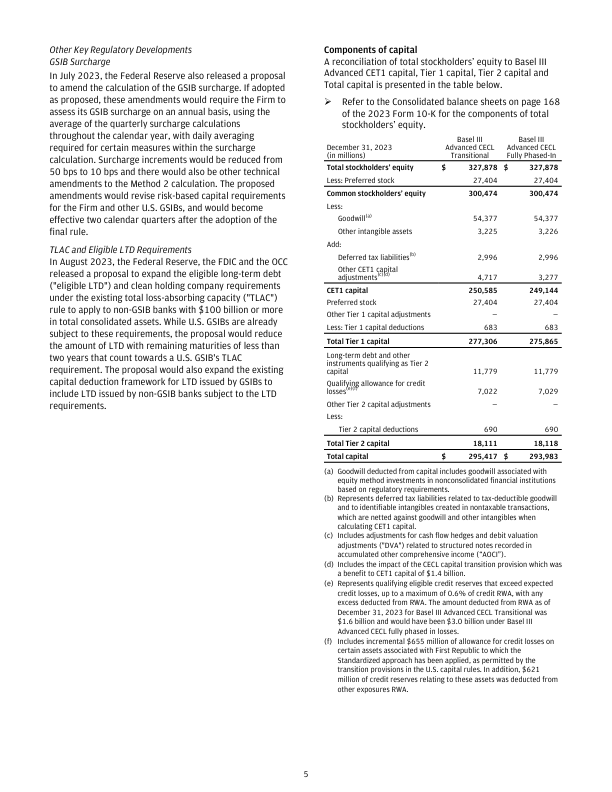

In [ ]:
# Display page to image example; change path accordingly
pdf_path = Path.cwd().parent / "data" / "JPMorgan" / "JPMorgan Chase & Co 4Q23 Basel Pillar 3 Report.pdf"
output_path = pdf_path.parent / "sample.png"
image_path = pdf_page_to_image(
    pdf_path=pdf_path, page_number=6, output_image_path=output_path
)
Image.open(image_path).convert("RGB")

## 4. Tabular information extraction via OpenAI API with multi-modal inputs (text + image)<a id="section-4"></a>

Text generation done using the standard OpenAI package, with prompt engineering inserted as the `system_prompt`. To feed images as inputs for the GPT models, the image would first need to be encoded in base64 and construct a data URL, before being included into the `user_prompt` input. The source of the system prompt comes from [Definition of capital in Basel III - Executive Summary](https://www.bis.org/fsi/fsisummaries/defcap_b3.pdf).

Examples shown in this section are based on J.P.Morgan Chase & Co's Q4 Pillar 3 disclosure reports from 2020 to 2023.

In [ ]:
def convert_image_to_data_url(image_path: Path) -> Optional[str]:
    """
    Converts a local image file into a data URL.

    This function reads an image file from the given path, encodes it in base64,
    and constructs a data URL that can be used in web applications.

    Args:
        * image_path (`Path`): The path to the image file.

    Returns:
        * `Optional[str]`: The data URL of the image, or None if the file cannot
        be read or the MIME type cannot be determined.
    """
    if not image_path.is_file():
        # Ensure the provided path is a file
        print(f"Error: The path {image_path} does not exist or is not a file.")
        return None

    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        # Default MIME type if none is found
        mime_type = "application/octet-stream"

    try:
        # Read and encode the image file
        with image_path.open("rb") as image_file:
            base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")
    except IOError as e:
        # Handle any I/O errors
        print(f"Error: Could not read the file {image_path}. IOError: {e}")
        return None

    # Construct the data URL
    data_url = f"data:{mime_type};base64,{base64_encoded_data}"
    return data_url


def multimodal_generation(
    system_prompt: str,
    user_prompt: str,
    image_path: Optional[Union[Path, str]] = None,
    model: Literal["gpt-3.5-turbo", "gpt-4", "gpt-4o"] = "gpt-4o",
    temperature: float = 0.0
) -> str:
    """
    Generate a response from the LLM based on system and user prompts, with an optional image input.

    Args:
        * system_prompt (`str`): The system prompt to define the assistant's role.
        * user_prompt (`str`): The user prompt to query specific information.
        * image_path (`Optional[Path]`): The path to the image file to be included
            in the query. Defaults to None.
        * model (`Literal`, optional): The GPT model to use. It maps to the
            predefined deployment names in the environment file. Options are
            "gpt-3.5-turbo", "gpt-4", or "gpt-4o". Defaults to "gpt-4o".
        * temperature (`float`, optional): Controls the randomness in the output
            generation. Higher values mean more randomness. Defaults to 0.0.

    Returns:
        `str`: The generated response from the assistant.

    Raises:
        `ValueError`: If an invalid deployment name is provided.
    """

    # Map the deployment names to their respective configurations
    deployment_mapping = {
        "gpt-3.5-turbo": config["AZURE_DEPLOYMENT_GPT_3_5"],
        "gpt-4": config["AZURE_DEPLOYMENT_GPT_4"],
        "gpt-4o": config["AZURE_DEPLOYMENT_GPT_4O"]
    }

    # Get the actual deployment name from the mapping
    chosen_deployment_name = deployment_mapping.get(model)

    # Deployment name validation check
    if chosen_deployment_name is None:
        raise ValueError(
            f"Invalid deployment name provided. Must be one of {list(deployment_mapping.keys())}"
        )

    # Prepare messages for the model
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    # If image path is provided, convert it to a data URL and include in the user prompt
    if image_path:
        data_url = convert_image_to_data_url(image_path)
        if data_url:
            messages[1]["content"] = [
                {"type": "text", "text": user_prompt},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]

    # Generate a response from the model with defined prompts and parameters
    response = client.chat.completions.create(
        model=chosen_deployment_name,
        temperature=temperature,
        messages=messages
    )

    # Return the generated response from the assistant
    return response.choices[0].message.content

In [ ]:
# We will use the following system prompt for all text generation tasks
system_prompt = """You are an expert in matters relating to the framework of capital \
requirements of banks. Total available regulatory capital is the sum of these two \
elements - Tier 1 capital, comprising Common Equity Tier 1 (CET1) and Additional \
Tier 1 (AT1), and Tier 2 capital. Each of the categories has a specific set of \
criteria that capital instruments are required to meet before their inclusion in \
the respective category. Banks are required to maintain specified minimum levels \
of CET1, Tier 1 and total capital, with each level set as a percentage of \
risk-weighted assets.
* CET1 is sum of common shares (equivalent for non-joint stock companies) and stock \
surplus, retained earnings, other comprehensive income, qualifying minority interest \
and regulatory adjustments.
* AT1 is the sum of capital instruments meeting the criteria for AT1 and related \
surplus, additional qualifying minority interest and regulatory adjustments.
* Tier 2 capital is the sum of capital instruments meeting the criteria for Tier 2 \
and related surplus, additional qualifying minority interest, qualifying loan \
loss provisions and regulatory adjustments.
"""

user_prompt = """Extract all information relating to Tier 1 or Tier 2 capital from \
the tables in the page."""

### 4.1 Test set 1 <a id="section-4-1"></a>

Examples shown in this section are based on [J.P.Morgan Chase & Co's Q4 2023 Pillar 3 disclosure report](https://jpmorganchaseco.gcs-web.com/static-files/91be4bd7-30e3-4770-981a-58c3fb1f3265).

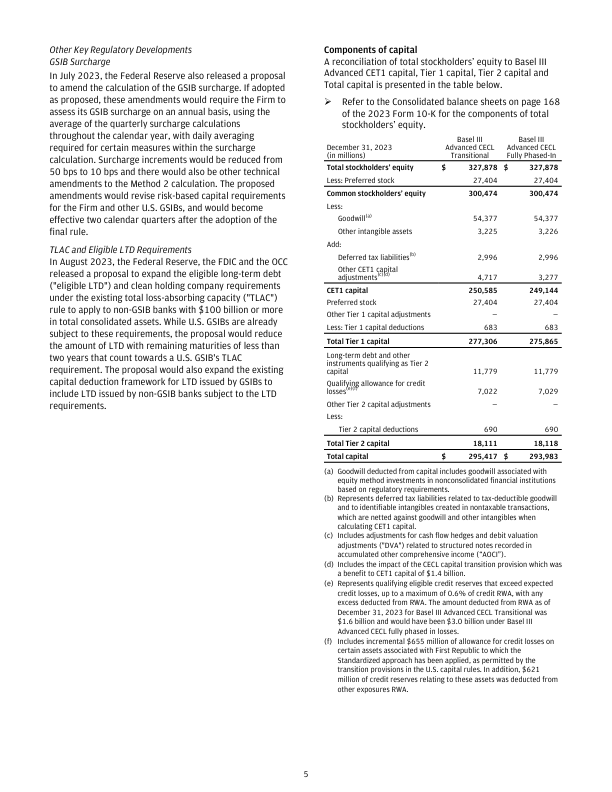

In [ ]:
# Display example image 1; change path accordingly
pdf_path = Path.cwd().parent / "data" / "JPMorgan" / "JPMorgan Chase & Co 4Q23 Basel Pillar 3 Report.pdf"
output_path = pdf_path.parent / "sample.png"
image_path = pdf_page_to_image(
    pdf_path=pdf_path, page_number=6, output_image_path=output_path
)
Image.open(image_path).convert("RGB")

In [ ]:
# Example use with image 1
response = multimodal_generation(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    model="gpt-4o",
    image_path=image_path
)
print(response)

Here is the extracted information relating to Tier 1 and Tier 2 capital from the provided table:

### Tier 1 Capital
- **CET1 Capital:**
  - Basel III Advanced CET1 Transitional: $250,585 million
  - Basel III Advanced CET1 Fully Phased-in: $249,144 million

- **Preferred Stock:**
  - Basel III Advanced CET1 Transitional: $27,404 million
  - Basel III Advanced CET1 Fully Phased-in: $27,404 million

- **Other Tier 1 Capital Adjustments:**
  - Basel III Advanced CET1 Transitional: $633 million
  - Basel III Advanced CET1 Fully Phased-in: $633 million

- **Less: Tier 1 Capital Deductions:**
  - Basel III Advanced CET1 Transitional: $633 million
  - Basel III Advanced CET1 Fully Phased-in: $633 million

- **Total Tier 1 Capital:**
  - Basel III Advanced CET1 Transitional: $277,306 million
  - Basel III Advanced CET1 Fully Phased-in: $275,865 million

### Tier 2 Capital
- **Long-term Debt and Other Instruments Qualifying as Tier 2 Capital:**
  - Basel III Advanced CET1 Transitional: $11,779

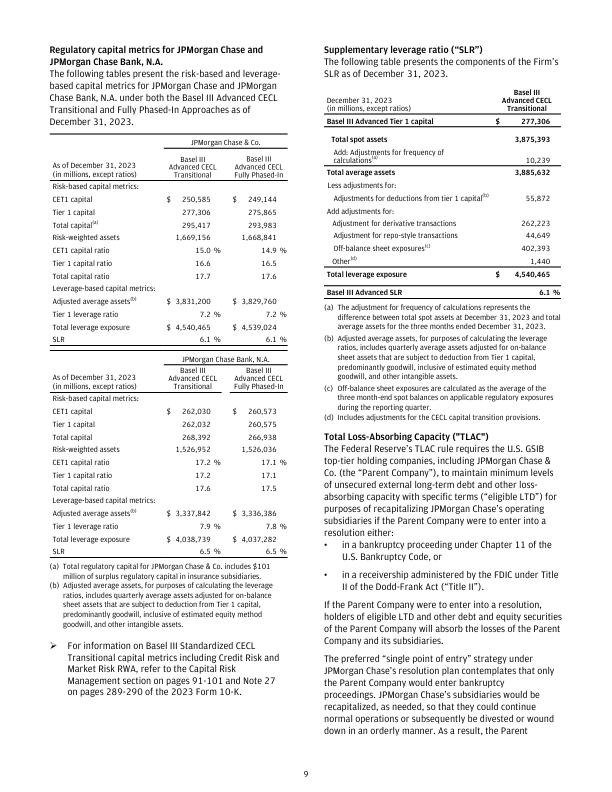

In [ ]:
# Display example image 2; change path accordingly
pdf_path = Path.cwd().parent / "data" / "JPMorgan" / "JPMorgan Chase & Co 4Q23 Basel Pillar 3 Report.pdf"
output_path = pdf_path.parent / "sample.png"
image_path = pdf_page_to_image(
    pdf_path=pdf_path, page_number=10, output_image_path=output_path
)
Image.open(image_path).convert("RGB")

In [ ]:
# Example use with image 2
response = multimodal_generation(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    model="gpt-4o",
    image_path=image_path
)
print(response)

Here is the extracted information relating to Tier 1 and Tier 2 capital from the tables on the page:

### JPMorgan Chase & Co.
#### Basel III Advanced CECL Transitional
- **Tier 1 capital**: $277,306 million
- **Tier 1 capital ratio**: 16.6%
- **Total capital**: $295,417 million
- **Total capital ratio**: 17.7%

#### Basel III Advanced CECL Fully Phased-In
- **Tier 1 capital**: $275,865 million
- **Tier 1 capital ratio**: 16.5%
- **Total capital**: $293,893 million
- **Total capital ratio**: 17.6%

### JPMorgan Chase Bank, N.A.
#### Basel III Advanced CECL Transitional
- **Tier 1 capital**: $262,032 million
- **Tier 1 capital ratio**: 17.2%
- **Total capital**: $268,392 million
- **Total capital ratio**: 17.6%

#### Basel III Advanced CECL Fully Phased-In
- **Tier 1 capital**: $260,575 million
- **Tier 1 capital ratio**: 17.1%
- **Total capital**: $266,938 million
- **Total capital ratio**: 17.5%

### Supplementary Leverage Ratio (SLR)
#### Basel III Advanced CECL Transitional
- **Tier

### 4.2 Test set 2 <a id="section-4-2"></a>

Examples shown in this section are based on [J.P.Morgan Chase & Co's Q4 2022 Pillar 3 disclosure report](https://jpmorganchaseco.gcs-web.com/static-files/211f3263-1405-4e12-9a5d-336848f266aa).

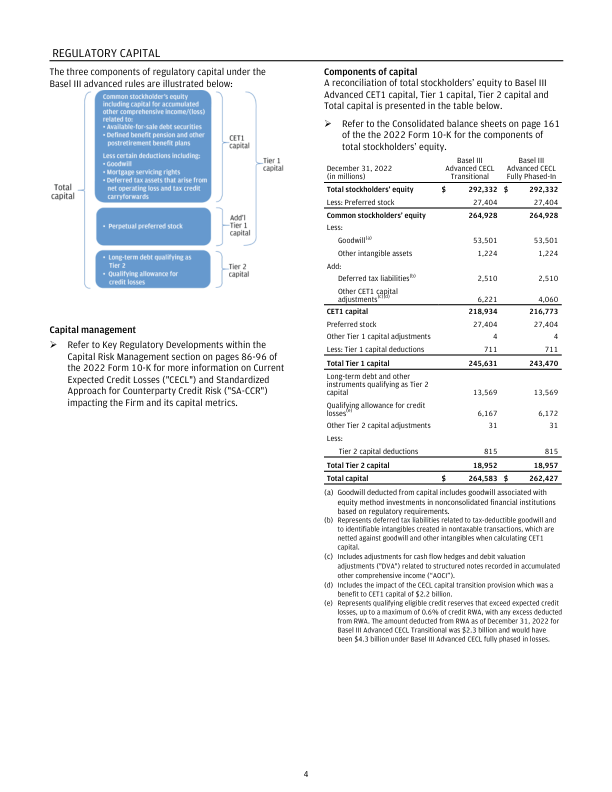

In [ ]:
# Display example image 1; change path accordingly
pdf_path = Path.cwd().parent / "data" / "JPMorgan" / "JPMorgan Chase & Co 4Q22 Basel Pillar 3 Report.pdf"
output_path = pdf_path.parent / "sample.png"
image_path = pdf_page_to_image(
    pdf_path=pdf_path, page_number=5, output_image_path=output_path
)
Image.open(image_path).convert("RGB")

In [ ]:
# Example use with image 1
response = multimodal_generation(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    model="gpt-4o",
    image_path=image_path
)
print(response)

Here is the extracted information relating to Tier 1 and Tier 2 capital from the provided table:

### Tier 1 Capital
- **CET1 Capital:**
  - Common stockholders' equity: $264,928 million
  - Less:
    - Goodwill: $53,501 million
    - Other intangible assets: $1,224 million
  - Add:
    - Deferred tax liabilities: $2,510 million
  - Other CET1 capital adjustments: $6,221 million (Transitional), $4,060 million (Fully phased-in)
  - **CET1 Capital Total:**
    - Transitional: $218,934 million
    - Fully phased-in: $216,773 million

- **Additional Tier 1 Capital:**
  - Preferred stock: $27,404 million
  - Other Tier 1 capital adjustments: $4 million
  - Less: Tier 1 capital deductions: $711 million
  - **Total Tier 1 Capital:**
    - Transitional: $245,631 million
    - Fully phased-in: $243,470 million

### Tier 2 Capital
- Long-term debt and other instruments qualifying as Tier 2 capital: $13,569 million
- Qualifying allowance for credit losses: $6,167 million (Transitional), $6,172 mi

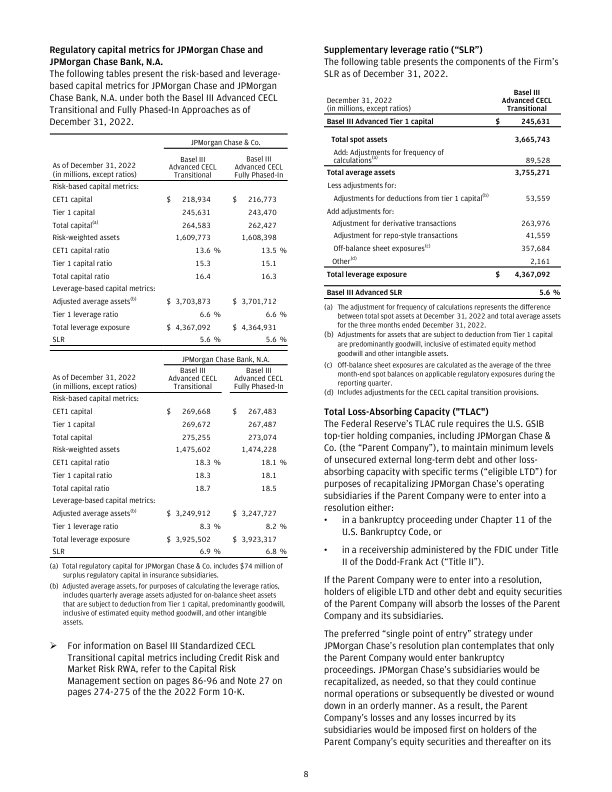

In [ ]:
# Display example image 2; change path accordingly
pdf_path = Path.cwd().parent / "data" / "JPMorgan" / "JPMorgan Chase & Co 4Q22 Basel Pillar 3 Report.pdf"
output_path = pdf_path.parent / "sample.png"
image_path = pdf_page_to_image(
    pdf_path=pdf_path, page_number=9, output_image_path=output_path
)
Image.open(image_path).convert("RGB")

In [ ]:
# Example use with image 2
response = multimodal_generation(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    model="gpt-4o",
    image_path=image_path
)
print(response)

Here is the extracted information relating to Tier 1 and Tier 2 capital from the tables on the page:

### JPMorgan Chase & Co.
#### Basel III Advanced (CECL Transitional)
- **Tier 1 capital**: $245,631 million
- **Tier 1 capital ratio**: 15.3%
- **Total capital**: $264,583 million
- **Total capital ratio**: 16.4%

#### Basel III Advanced (CECL Fully Phased-In)
- **Tier 1 capital**: $243,470 million
- **Tier 1 capital ratio**: 15.1%
- **Total capital**: $262,427 million
- **Total capital ratio**: 16.3%

### JPMorgan Chase Bank, N.A.
#### Basel III Advanced (CECL Transitional)
- **Tier 1 capital**: $269,672 million
- **Tier 1 capital ratio**: 18.3%
- **Total capital**: $275,255 million
- **Total capital ratio**: 18.7%

#### Basel III Advanced (CECL Fully Phased-In)
- **Tier 1 capital**: $267,487 million
- **Tier 1 capital ratio**: 18.1%
- **Total capital**: $273,074 million
- **Total capital ratio**: 18.5%

### Supplementary Leverage Ratio (SLR)
#### Basel III Advanced (CECL Transitional

### 4.3 Test set 3 <a id="section-4-3"></a>

Examples shown in this section are based on [J.P.Morgan Chase & Co's Q4 2021 Pillar 3 disclosure report](https://jpmorganchaseco.gcs-web.com/static-files/557ed4c1-feaa-49e5-bdc5-8ae4cbc3dd4a).

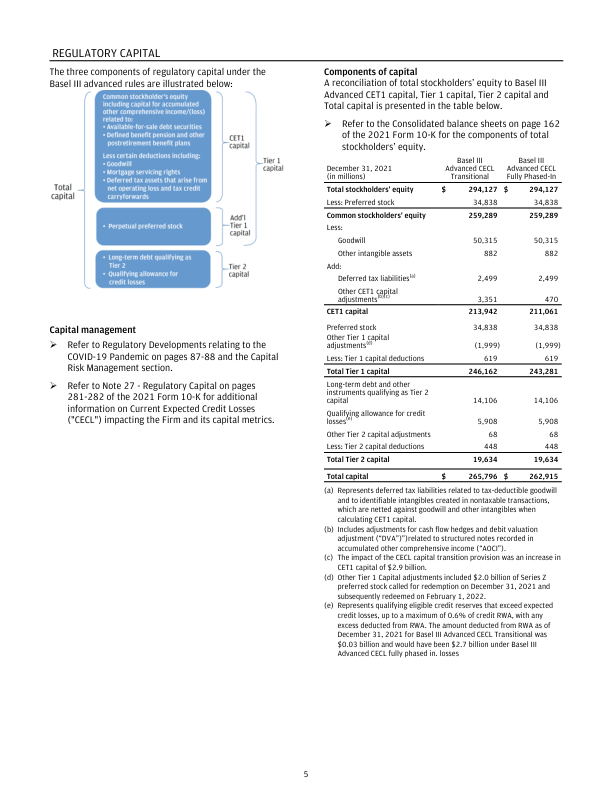

In [ ]:
# Display example image 1; change path accordingly
pdf_path = Path.cwd().parent / "data" / "JPMorgan" / "JPMorgan Chase & Co 4Q21 Basel Pillar 3 Report.pdf"
output_path = pdf_path.parent / "sample.png"
image_path = pdf_page_to_image(
    pdf_path=pdf_path, page_number=6, output_image_path=output_path
)
Image.open(image_path).convert("RGB")

In [ ]:
# Example use with image 1
response = multimodal_generation(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    model="gpt-4o",
    image_path=image_path
)
print(response)

Here is the extracted information relating to Tier 1 and Tier 2 capital from the provided page:

### Tier 1 Capital
- **Common stockholders' equity**: $259,289 million
- **Less:**
  - Goodwill: $50,315 million
  - Other intangible assets: $832 million
- **Add:**
  - Deferred tax liabilities: $2,499 million
  - Other CET1 capital adjustments: $3,351 million (Basel III Advanced CECL Transitional), $470 million (Basel III Advanced CECL Fully Phased-In)
- **CET1 capital**: $213,942 million (Basel III Advanced CECL Transitional), $211,061 million (Basel III Advanced CECL Fully Phased-In)
- **Preferred stock**: $34,838 million
- **Other Tier 1 capital adjustments**: $(1,999) million
- **Less: Tier 1 capital deductions**: $619 million
- **Total Tier 1 capital**: $246,162 million (Basel III Advanced CECL Transitional), $243,281 million (Basel III Advanced CECL Fully Phased-In)

### Tier 2 Capital
- **Long-term debt and other instruments qualifying as Tier 2 capital**: $14,106 million
- **Quali

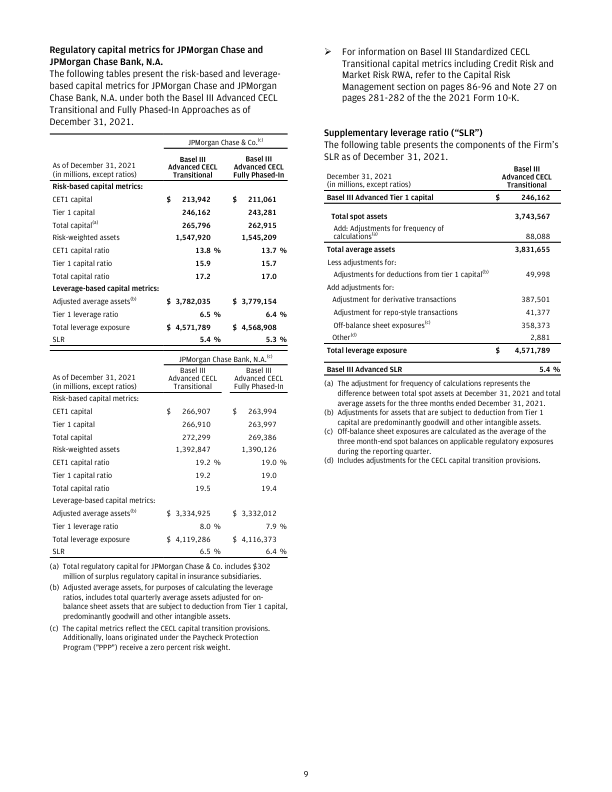

In [ ]:
# Display example image 2; change path accordingly
pdf_path = Path.cwd().parent / "data" / "JPMorgan" / "JPMorgan Chase & Co 4Q21 Basel Pillar 3 Report.pdf"
output_path = pdf_path.parent / "sample.png"
image_path = pdf_page_to_image(
    pdf_path=pdf_path, page_number=10, output_image_path=output_path
)
Image.open(image_path).convert("RGB")

In [ ]:
# Example use with image 2
response = multimodal_generation(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    model="gpt-4o",
    image_path=image_path
)
print(response)

Here is the extracted information relating to Tier 1 and Tier 2 capital from the tables on the page:

### JPMorgan Chase & Co.
#### Basel III Advanced CECL Transitional
- **Tier 1 capital**: $246,162 million
- **Total capital**: $265,796 million
- **Tier 1 capital ratio**: 13.8%
- **Total capital ratio**: 17.2%
- **Tier 1 leverage ratio**: 6.5%

#### Basel III Advanced CECL Fully Phased-In
- **Tier 1 capital**: $243,281 million
- **Total capital**: $262,915 million
- **Tier 1 capital ratio**: 13.7%
- **Total capital ratio**: 17.0%
- **Tier 1 leverage ratio**: 6.4%

### JPMorgan Chase Bank, N.A.
#### Basel III Advanced CECL Transitional
- **Tier 1 capital**: $266,910 million
- **Total capital**: $272,299 million
- **Tier 1 capital ratio**: 19.2%
- **Total capital ratio**: 19.5%
- **Tier 1 leverage ratio**: 8.0%

#### Basel III Advanced CECL Fully Phased-In
- **Tier 1 capital**: $263,997 million
- **Total capital**: $269,386 million
- **Tier 1 capital ratio**: 19.0%
- **Total capital rat

### 4.4 Test set 4 <a id="section-4-4"></a>

Examples shown in this section are based on [J.P.Morgan Chase & Co's Q4 2020 Pillar 3 disclosure report](https://jpmorganchaseco.gcs-web.com/static-files/17b49af2-ee6c-43dd-b856-ef47fe4b4805).

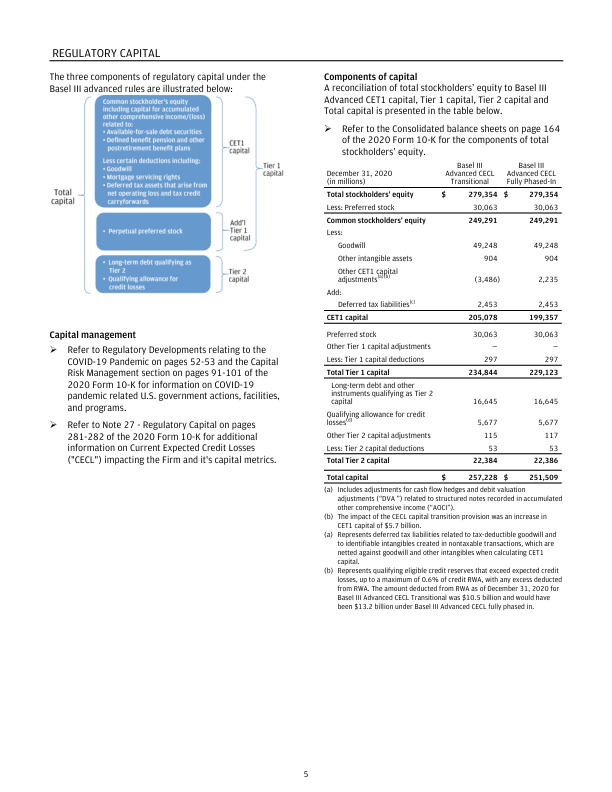

In [ ]:
# Display example image 1; change path accordingly
pdf_path = Path.cwd().parent / "data" / "JPMorgan" / "JPMorgan Chase & Co 4Q20 Basel Pillar 3 Disclosure.pdf"
output_path = pdf_path.parent / "sample.png"
image_path = pdf_page_to_image(
    pdf_path=pdf_path, page_number=6, output_image_path=output_path
)
Image.open(image_path).convert("RGB")

In [ ]:
# Example use with image 1
response = multimodal_generation(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    model="gpt-4o",
    image_path=image_path
)
print(response)

Here is the extracted information relating to Tier 1 and Tier 2 capital from the provided page:

### Tier 1 Capital
- **Common Equity Tier 1 (CET1) Capital:**
  - Common stockholders' equity: $249,291 million
  - Less:
    - Goodwill: $49,248 million
    - Other intangible assets: $904 million
    - Other CET1 capital adjustments: $3,846 million
  - Add:
    - Deferred tax liabilities: $2,453 million
  - **CET1 Capital:**
    - Basel III Advanced CECL Transitional: $205,073 million
    - Basel III Advanced CECL Fully Phased-In: $199,357 million

- **Additional Tier 1 (AT1) Capital:**
  - Preferred stock: $30,063 million
  - Other Tier 1 capital adjustments: $6,577 million
  - Less:
    - Tier 1 capital deductions: $297 million
  - **Total Tier 1 Capital:**
    - Basel III Advanced CECL Transitional: $234,844 million
    - Basel III Advanced CECL Fully Phased-In: $229,123 million

### Tier 2 Capital
- Long-term debt and other instruments qualifying as Tier 2 capital: $16,645 million
- Q

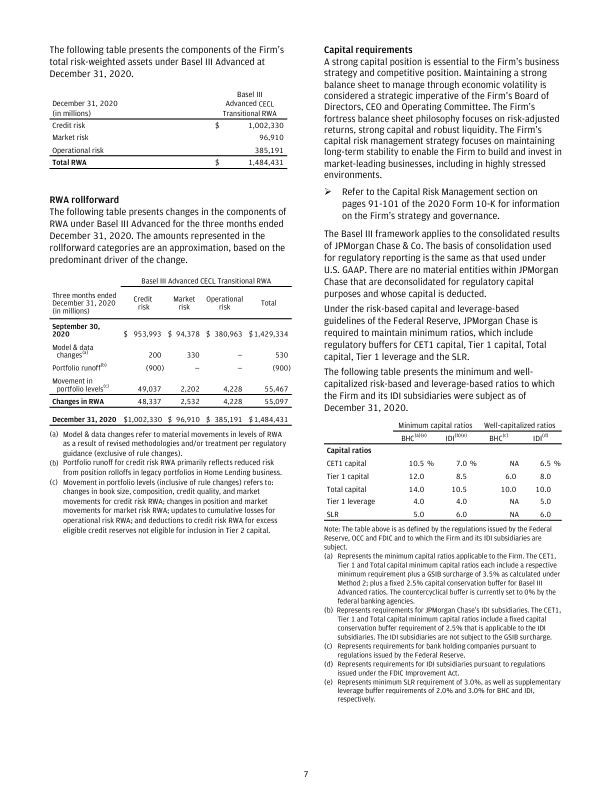

In [ ]:
# Display example image 2; change path accordingly
pdf_path = Path.cwd().parent / "data" / "JPMorgan" / "JPMorgan Chase & Co 4Q20 Basel Pillar 3 Disclosure.pdf"
output_path = pdf_path.parent / "sample.png"
image_path = pdf_page_to_image(
    pdf_path=pdf_path, page_number=8, output_image_path=output_path
)
Image.open(image_path).convert("RGB")

In [ ]:
# Example use with image 2
response = multimodal_generation(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    model="gpt-4o",
    image_path=image_path
)
print(response)

The information relating to Tier 1 and Tier 2 capital from the provided page is as follows:

### Capital Requirements
- **Tier 1 Capital**:
  - CET1 capital: 10.5% minimum, 7.0% well-capitalized
  - Tier 1 capital: 12.0% minimum, 8.5% well-capitalized

- **Tier 2 Capital**:
  - Total capital: 14.0% minimum, 10.0% well-capitalized

### Notes:
- The minimum capital ratios are defined by the regulations issued by the Federal Reserve, OCC, and FDIC.
- The CET1, Tier 1, and Total capital minimum capital ratios include a minimum requirement plus a GSIB surcharge of 3.5% and a 2.5% capital conservation buffer for Basel III Advanced approaches.
- The requirements for JPMorgan Chase & Co. and its subsidiaries include:
  - CET1 capital: 10.5% minimum, 7.0% well-capitalized
  - Tier 1 capital: 12.0% minimum, 8.5% well-capitalized
  - Total capital: 14.0% minimum, 10.0% well-capitalized

- The SLR (Supplementary Leverage Ratio) requirements are 5.0% minimum and 6.0% well-capitalized for JPMorgan C

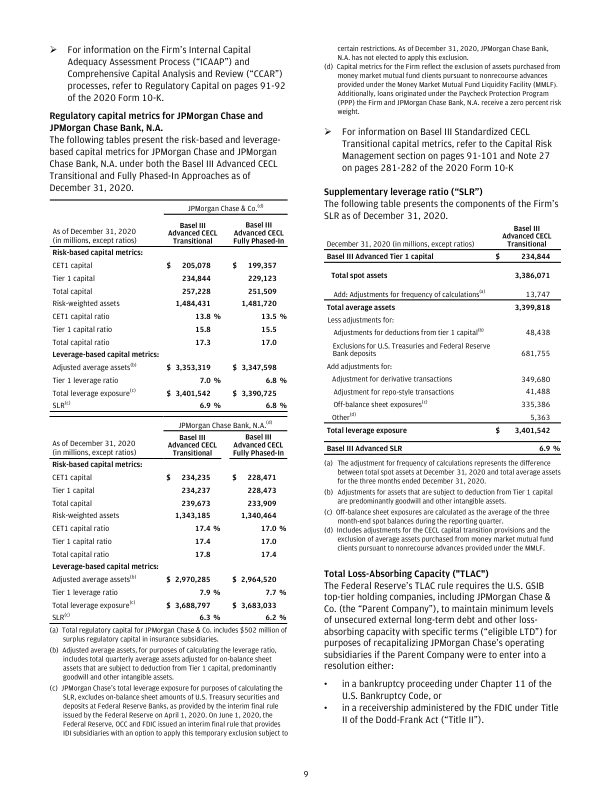

In [ ]:
# Display example image 3; change path accordingly
pdf_path = Path.cwd().parent / "data" / "JPMorgan" / "JPMorgan Chase & Co 4Q20 Basel Pillar 3 Disclosure.pdf"
output_path = pdf_path.parent / "sample.png"
image_path = pdf_page_to_image(
    pdf_path=pdf_path, page_number=10, output_image_path=output_path
)
Image.open(image_path).convert("RGB")

In [ ]:
# Example use with image 3
response = multimodal_generation(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    model="gpt-4o",
    image_path=image_path
)
print(response)

Here is the extracted information relating to Tier 1 and Tier 2 capital from the tables on the page:

### JPMorgan Chase & Co.
#### Risk-based capital metrics:
- **Tier 1 capital:**
  - Base III Advanced CECL Transitional: $234,844 million
  - Base III Advanced CECL Fully Phased-In: $229,123 million

- **Total capital:**
  - Base III Advanced CECL Transitional: $257,228 million
  - Base III Advanced CECL Fully Phased-In: $251,509 million

- **Tier 1 capital ratio:**
  - Base III Advanced CECL Transitional: 15.8%
  - Base III Advanced CECL Fully Phased-In: 15.5%

- **Total capital ratio:**
  - Base III Advanced CECL Transitional: 17.3%
  - Base III Advanced CECL Fully Phased-In: 17.0%

### JPMorgan Chase Bank, N.A.
#### Risk-based capital metrics:
- **Tier 1 capital:**
  - Base III Advanced CECL Transitional: $234,235 million
  - Base III Advanced CECL Fully Phased-In: $228,473 million

- **Total capital:**
  - Base III Advanced CECL Transitional: $239,673 million
  - Base III Advanced 